In [4]:
import numpy as np
import numpy.linalg as LA
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [5]:
# nearPD(A) calc projection of A to pd
import numpy as np

def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return np.array(Yk)

In [64]:
n = 1000
m = 3*n
eps = 0.1
data_dim = 2
mu = 0
mu_out = 6
par_mu = np.full(data_dim, mu)
# par_sd = np.identity(data_dim)
out_mu = np.full(data_dim, mu_out)

par_reg1=0.005
exper_iter = 3
optim_iter = 50
L = 5
learn_par = 0.005
dicay_par = 0.3

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20



def create_out_cov(data_dim):
    return_cov = np.zeros([data_dim, data_dim])
    for i in range(data_dim):
        for j in range(i+1):
            z = np.random.uniform(0.4, 0.8)
            gamma = np.random.binomial(n = 1,p=0.1)
            return_cov[i][j] = z*gamma
            return_cov[j][i] = z*gamma
    return_cov = return_cov +(np.abs(np.linalg.eig(return_cov)[0]) +0.05)*np.identity(data_dim)
    return return_cov

In [65]:
# 分散を固定しない
par_cov = np.eye(data_dim)
out_cov = np.eye(data_dim)
true_alpha = [par_mu, par_cov]
res_mu = [0 for i in range(exper_iter)]
res_cov = [0 for i in range(exper_iter)]
res_par = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    data = np.random.multivariate_normal(mean = par_mu, cov = par_cov, size = int(n*(1-eps)))
    # Gaoの論文の設定
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_cov, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    cov_hist = []
    par_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    alpha = [np.median(data, axis=0), np.cov(data, rowvar = False)]
    z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
    par = np.random.normal(loc = 0, scale = 0.1, size = 2*data_dim)
    bias = np.array(np.mean(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim])))[np.newaxis]
    par = np.concatenate([par, bias], axis = 0)
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
        def major_func(par, past_par):
            new_beta = par[0:2*data_dim]; new_b = par[2*data_dim]; beta = past_par[0:2*data_dim]; b = past_par[2*data_dim]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),new_beta)       - new_b, np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),beta) - b))
            B = np.mean(g_up(np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),beta) - b))
            reg = LA.norm(par[:4], ord=2)*par_reg1
            return -(A-B -reg)
        
        l = 0
        while(l<L):
            op = minimize(major_func, x0 = par, args = par)
            par = op.x
            l+=1
        
        alpha_m = alpha[0]; alpha_v = alpha[1]
        v_inv = LA.inv(alpha_v)
        mgrad = (v_inv*(z-alpha_m)[:, np.newaxis, :]).sum(axis=2)
        sigma_grad = (alpha_v - (z- alpha_m)[:,:,np.newaxis] * (z-alpha_m)[:, np.newaxis, :])/2
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim ])- par[2*data_dim])[:,np.newaxis]
        tmp_alpha_m = alpha_m- learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        tmp_alpha_v = v_inv - learn_par/j**dicay_par * np.mean(sigma_grad*sig_[:,:,np.newaxis], axis = 0)
        alpha[0], alpha[1] = tmp_alpha_m, (LA.inv(tmp_alpha_v))

        alpha_hist.append(alpha[0])
        cov_hist.append(alpha[1])
        par_hist.append(par)
    res_mu[i] = alpha_hist
    res_cov[i] =  cov_hist
    res_par[i] = par_hist



1/3


100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


2/3


100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


3/3


100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


In [39]:
def plot():
    mean = np.array(res_mu)
    cov = np.array(res_cov)
    par = np.array(res_par)
    mean_vec = np.full(data_dim, mu)
    cov_mat = np.eye(data_dim)
    
    mean_end = []; cov_end = []
    for i in range(exper_iter):
        loss_mean = LA.norm(mean[i] - mean_vec, ord = 2, axis = 1)
        plt.plot(loss_mean)
        mean_end.append(loss_mean[-1])
    print("mean ave : %.5f" %np.mean(mean_end))
    print("mean std : %.5f" %np.std(mean_end))


    plt.subplots()
    for i in range(exper_iter):
        loss_cov = LA.norm(cov[i] - cov_mat, ord = 2, axis = (1,2))
        plt.plot(loss_cov)
        cov_end.append(loss_cov[-1])
    print("cov  ave : %.5f" %np.mean(cov_end))
    print("cov  std : %.5f" %np.std(cov_end))

    for i in range(exper_iter):
        plt.subplots()
        for j in range(par.shape[2]):
            plt.plot(par[i,:,j], label=str(j))
            plt.legend()
        


def plot_sig():
    mean = np.array(res_mu)
    cov = np.array(res_cov)
    par = np.array(res_par)
    for j in range(exper_iter):
        l = []
        for i in range(optim_iter):
            z = np.random.multivariate_normal(mean[j,i], cov[j,i], size = 3000)
            par_ = par[j,i]
            sig_ = (sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par_[0:2*data_dim ])- par_[2*data_dim])[:,np.newaxis]).mean()
            l.append(sig_)


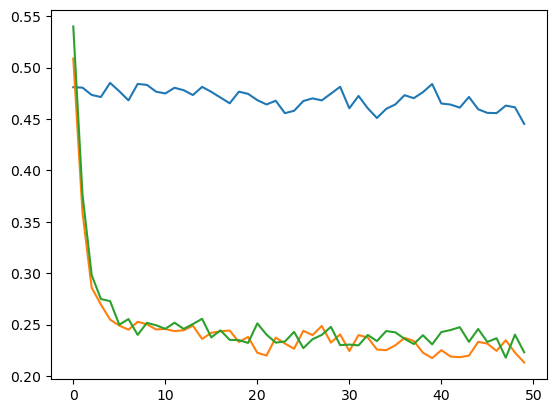

In [70]:
plot_sig()

mean ave : 0.24148
mean std : 0.01659
cov  ave : 3.83971
cov  std : 0.42218


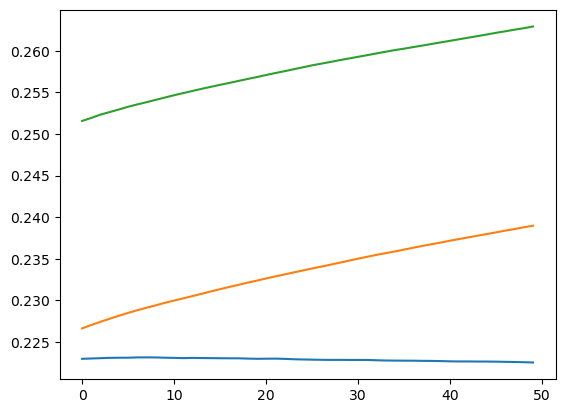

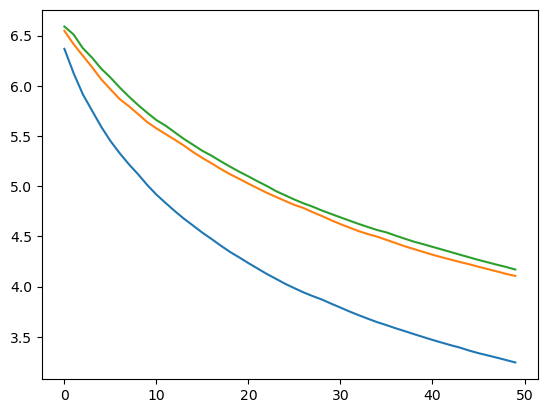

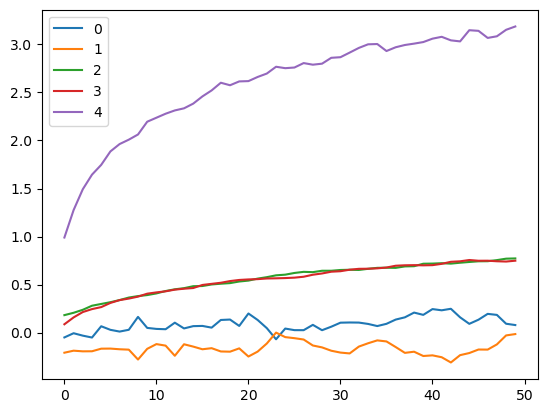

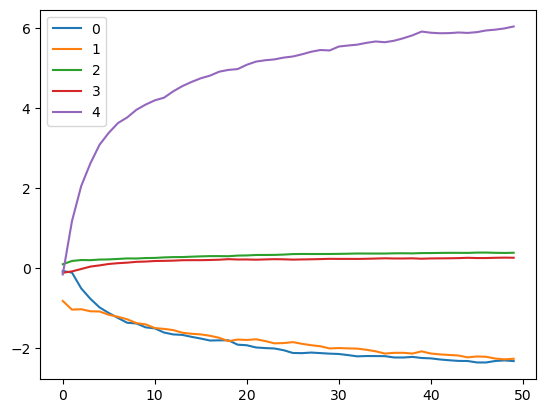

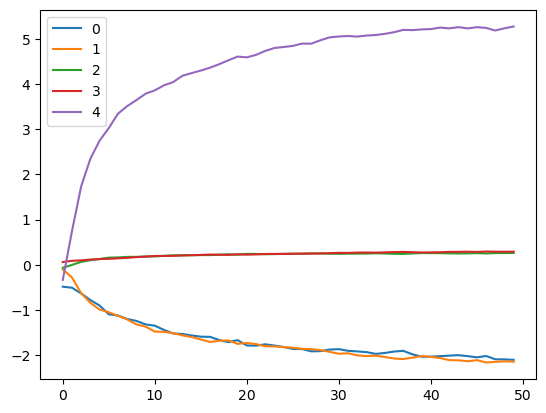

In [71]:
plot()